In [1]:
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import gala.potential as gp
import gala.dynamics as gd
import pandas as pd
import sfdmap

from scipy.interpolate import interp1d
from matplotlib.patches import Rectangle

In [2]:
# Galactocentric frame post-Gaia (defaults from astropy v4.0)
coord.galactocentric_frame_defaults.set('v4.0')

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [3]:
# potential default from gala
potential = gp.MilkyWayPotential()

In [4]:
# parameters for orbit integration
timestep = 0.05 * u.Myr
totaltime = 25*u.Myr
nsteps = (totaltime / timestep).to(u.dimensionless_unscaled)

In [5]:
# NGC 3201 coordinates
icrs = coord.SkyCoord(ra=154.403*u.deg,
                      dec=-46.412*u.deg,
                      distance=4.9*u.kpc,
                      pm_ra_cosdec=8.324*u.mas/u.yr,
                      pm_dec=-1.991*u.mas/u.yr,
                      radial_velocity=494.34*u.km/u.s)

In [6]:
galcen = icrs.transform_to(coord.Galactocentric)
w0 = gd.PhaseSpacePosition(galcen.data)
orbit = potential.integrate_orbit(w0, dt=-timestep, n_steps=nsteps)

sc = coord.SkyCoord(x=orbit.x, y=orbit.y, z=orbit.z,
                    v_x=orbit.v_x, v_y=orbit.v_y, v_z=orbit.v_z,
                    frame=coord.Galactocentric)
orbit_gal = sc.transform_to(coord.Galactic)
orbit_icrs = sc.transform_to(coord.ICRS)

# Get Ibata+19 data

```
SELECT source_id, ra, dec, pmra, pmra_error, pmdec, pmdec_error, parallax, parallax_error, phot_g_mean_mag AS g, bp_rp, dist.r_est, dist.r_lo, dist.r_hi, dist.result_flag, dist.modality_flag
FROM gaiadr2.gaia_source
JOIN external.gaiadr2_geometric_distance AS dist USING (source_id)
WHERE source_id IN (3200439105894310272, 3254112556278356608, 3187390548572555136, 3229373063616887936, 3188058536245928576, 2985543956292701312)
```
cross-match radial velocity measurements by hand

In [7]:
df_ibata = pd.read_csv('../data/gjoll-candidates/ibata19.csv')
df_ibata['v_hel_ibata'] = [74.41, -10.92, 0.81, -15.18, -33.17, -80.44]
df_ibata['v_hel_err_ibata'] = [1.51, 0.28, 3.18, 4.38, 0.65, 0.26]
df_ibata['good_cand_ibata'] = ['Y', 'Y', 'N', 'Y', 'N', 'N']
ibata = coord.SkyCoord(ra=df_ibata['ra'].values*u.deg,
                    dec=df_ibata['dec'].values*u.deg,
                    pm_ra_cosdec=df_ibata['pmra'].values*u.mas/u.yr,
                    pm_dec=df_ibata['pmdec'].values*u.mas/u.yr,
                    radial_velocity=df_ibata['v_hel_ibata'].values*u.km/u.s)
ibata_gal = ibata.transform_to(coord.Galactic)

## Selecting out new Gjoll stars from Gaia

### liberal
```
SELECT source_id, ra, dec, pmra, pmdec, phot_g_mean_mag as g, phot_bp_mean_mag as bp, phot_rp_mean_mag as rp
FROM gaiadr2.gaia_source
WHERE phot_g_mean_mag <= 15
AND l > 180 AND l < 230
AND b > -35 AND b < -10
AND pmra > 15 AND pmra < 25
AND pmdec > -25 AND pmdec < -15
AND parallax > -1 AND parallax < 1
```

### socialist
```
SELECT source_id, ra, dec, pmra, pmra_error, pmdec, pmdec_error, parallax, parallax_error, phot_g_mean_mag AS g, bp_rp, dist.r_est, dist.r_lo, dist.r_hi, dist.result_flag, dist.modality_flag
FROM gaiadr2.gaia_source
JOIN external.gaiadr2_geometric_distance AS dist USING (source_id)
WHERE phot_g_mean_mag <= 15
AND l > 180 AND l < 280
AND b > -35 AND b < 10
AND pmra > 5 AND pmra < 25
AND pmdec > -25 AND pmdec < 0
AND parallax > -1 AND parallax < 1
```

In [8]:
df = pd.read_csv('../data/gjoll-candidates/faint-input.csv')
sc = coord.SkyCoord(ra=df['ra'].values*u.deg,
                    dec=df['dec'].values*u.deg,
                    pm_ra_cosdec=df['pmra'].values*u.mas/u.yr,
                    pm_dec=df['pmdec'].values*u.mas/u.yr)

In [9]:
# interpolate pmra, pmdec, and b as a function of l
x = orbit_gal.l.value
y = np.vstack([orbit_icrs.pm_ra_cosdec.value,
               orbit_icrs.pm_dec.value,
               orbit_gal.b.value,
               orbit_gal.distance.value,
               orbit_gal.distance.parallax.value])
f = interp1d(x,y, fill_value=[-99,-99,-99,np.inf,-99], bounds_error=False)
pmra, pmdec, b, distance, parallax = f(sc.transform_to(coord.Galactic).l)

In [10]:
# cut based on tolerances
sel = np.abs(pmra * u.mas/u.yr - sc.pm_ra_cosdec) < 1.5 * u.mas/u.yr
sel &= np.abs(pmdec * u.mas/u.yr - sc.pm_dec) < 1.5 * u.mas/u.yr
sel &= np.abs(parallax - df['parallax'])/df['parallax_error'] < 4
sel &= np.abs(b * u.deg - sc.transform_to(coord.Galactic).b) < 3*u.deg

in_cluster = sc.transform_to(coord.Galactic).l > 275 * u.deg

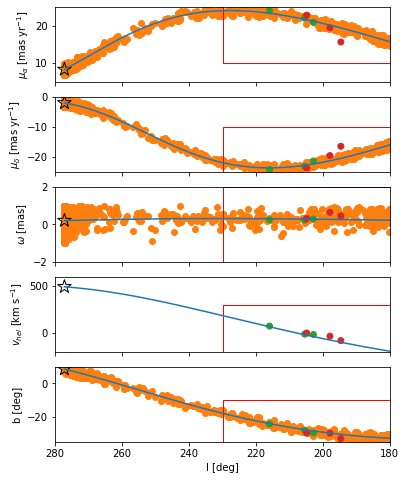

In [11]:
sc_icrs = sc[sel].transform_to(coord.ICRS)
sc_gal = sc_icrs.transform_to(coord.Galactic)

fig, ax = plt.subplots(5, 1, sharex='col', sharey='row', figsize=(6,8))
ax[-1].set_xlim(280,180)
ax[-1].set_xlabel('l [deg]')
colormap = {'Y': 'C2', 'N': 'C3'}
ibata_colors = [colormap[choice] for choice in df_ibata['good_cand_ibata']]

# pm_ra
ax[0].plot(orbit_gal.l, orbit_icrs.pm_ra_cosdec)
ax[0].scatter(sc_gal.l, sc_icrs.pm_ra_cosdec, c='C1')
ax[0].scatter(ibata_gal.l, ibata.pm_ra_cosdec, c=ibata_colors)
ax[0].scatter(orbit_gal[0].l, orbit_icrs[0].pm_ra_cosdec, marker='*', s=200, facecolors='none', edgecolors='k')
ax[0].set_ylim(5,25)
ax[0].set_ylabel(r'$\mu_\alpha$ [mas yr$^{-1}$]')

# pm_dec
ax[1].plot(orbit_gal.l, orbit_icrs.pm_dec)
ax[1].scatter(sc_gal.l, sc_icrs.pm_dec, c='C1')
ax[1].scatter(ibata_gal.l, ibata.pm_dec, c=ibata_colors)
ax[1].scatter(orbit_gal[0].l, orbit_icrs[0].pm_dec, marker='*', s=200, facecolors='none', edgecolors='k')
ax[1].set_ylim(-25,0)
ax[1].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')

# parallax
ax[2].plot(orbit_gal.l, orbit_icrs.distance.parallax)
ax[2].scatter(sc_gal.l, df[sel]['parallax'], c='C1')
ax[2].scatter(ibata_gal.l, df_ibata['parallax'], c=ibata_colors)
ax[2].scatter(orbit_gal[0].l, orbit_icrs[0].distance.parallax, marker='*', s=200, facecolors='none', edgecolors='k')
ax[2].set_ylim(-2,2)
ax[2].set_ylabel(r'$\omega$ [mas]')

# v_hel
ax[3].plot(orbit_gal.l, orbit_icrs.radial_velocity)
ax[3].scatter(ibata_gal.l, ibata.radial_velocity, c=ibata_colors)
ax[3].scatter(orbit_gal[0].l, orbit_icrs[0].radial_velocity, marker='*', s=200, facecolors='none', edgecolors='k')
ax[3].set_ylim(-200,600)
ax[3].set_ylabel(r'$v_{hel}$ [km s$^{-1}$]')

# sky position
ax[4].plot(orbit_gal.l, orbit_gal.b)
ax[4].scatter(sc_gal.l, sc_gal.b, c='C1')
ax[4].scatter(ibata_gal.l, ibata_gal.b, c=ibata_colors)
ax[4].scatter(orbit_gal[0].l, orbit_gal[0].b, marker='*', s=200, facecolors='none', edgecolors='k')
ax[4].set_ylim(-35,10)
ax[4].set_ylabel('b [deg]');

# add rectangles
rect_dict = {'linewidth': 1, 'edgecolor': 'r', 'facecolor': 'none'}
ax[0].add_patch(Rectangle((180,10),50,30,**rect_dict))
ax[1].add_patch(Rectangle((180,-40),50,30,**rect_dict))
ax[2].add_patch(Rectangle((180,-2),50,4,**rect_dict))
ax[3].add_patch(Rectangle((180,-200),50,500,**rect_dict))
ax[4].add_patch(Rectangle((180,-40),50,30,**rect_dict));

# Calculate extinction-corrected values

Using the [sfdmap](https://github.com/kbarbary/sfdmap) package which calculates extinction on the sky using the Schlafly & Finkbeiner (2011) corrections to the Schlegel et al. (1998) maps.

In [12]:
m_g = sfdmap.SFDMap('$HOME/sfddata/', scaling=0.85926)
m_bp = sfdmap.SFDMap('$HOME/sfddata/', scaling=1.06794)
m_rp = sfdmap.SFDMap('$HOME/sfddata/', scaling=0.65199)

# correct ibata
df_ibata['g0'] = df_ibata['g'] - 3.1*m_g.ebv(df_ibata['ra'].values, df_ibata['dec'].values, unit='degree')
df_ibata['bp_rp0'] = df_ibata['bp_rp']
df_ibata['bp_rp0'] -= 3.1*m_bp.ebv(df_ibata['ra'].values, df_ibata['dec'].values, unit='degree')
df_ibata['bp_rp0'] += 3.1*m_rp.ebv(df_ibata['ra'].values, df_ibata['dec'].values, unit='degree')

# correct data
df['g0'] = df['g'] - 3.1*m_g.ebv(df['ra'].values, df['dec'].values, unit='degree')
df['bp_rp0'] = df['bp_rp']
df['bp_rp0'] -= 3.1*m_bp.ebv(df['ra'].values, df['dec'].values, unit='degree')
df['bp_rp0'] += 3.1*m_rp.ebv(df['ra'].values, df['dec'].values, unit='degree')

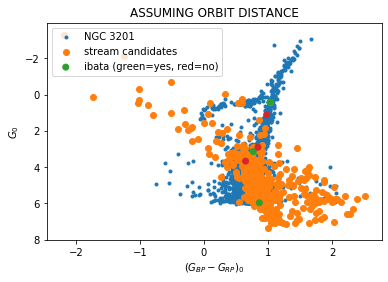

In [13]:
# also think about color-magnitude space
G = df['g0'] - coord.Distance(distance*u.kpc).distmod.value
G_ibata = df_ibata['g0'] - coord.Distance(f(ibata_gal.l)[3]*u.kpc).distmod.value
plt.scatter(df['bp_rp0'][sel & in_cluster], G[sel & in_cluster], marker='.', label='NGC 3201')
plt.scatter(df['bp_rp0'][sel & ~in_cluster], G[sel & ~in_cluster], marker='o', label='stream candidates')
plt.scatter(df_ibata['bp_rp0'], G_ibata, marker='o', color=ibata_colors, label='ibata (green=yes, red=no)')
plt.gca().invert_yaxis()
plt.xlabel(r'$(G_{BP} - G_{RP})_0$')
plt.ylabel(r'$G_0$')
plt.title('ASSUMING ORBIT DISTANCE')
plt.legend(loc='best');

In [15]:
cmdbad = (df['bp_rp0'] < 0) | (df['bp_rp0'] > 1)
cmdbad |= (G > 1) & (df['bp_rp0'] < 0.75)

# Add metadata for Terese to observe

In [16]:
good = sel & ~in_cluster & ~cmdbad
cand = df[good].copy()

# merge with Ibata results for convenience
cand = pd.concat([df_ibata, cand], sort=False)
cand.drop_duplicates(subset=['source_id'], inplace=True) # keep the Ibata entry if duplicated
cand['good_cand_ibata'].fillna('NA', inplace=True)

# helpful stuff for Terese
cand.set_index('source_id', inplace=True)
cand['coordstring'] = coord.SkyCoord(cand['ra'], cand['dec'], unit='deg').to_string('hmsdms')
cand['johnson_V'] = cand['g'] - (-0.01760 - 0.006860*cand['bp_rp'] - 0.1732*(cand['bp_rp']**2))

In [17]:
# re-identify already observed objects
cand['other_id'] = ''
cand.loc[3200439105894310272, 'other_id'] = 'ibata_1'
cand.loc[3254112556278356608, 'other_id'] = 'gjoll_1' # ibata_2
cand.loc[3187390548572555136, 'other_id'] = 'gjoll_2' # ibata_3
cand.loc[3229373063616887936, 'other_id'] = 'gjoll_3' # ibata_4
cand.loc[3188058536245928576, 'other_id'] = 'ibata_5'
cand.loc[2985543956292701312, 'other_id'] = 'ibata_6'
cand.loc[2990142148280216960, 'other_id'] = 'gjoll_4'
cand.loc[3259158764894232192, 'other_id'] = 'gjoll_5'
cand.loc[3258976074166599680, 'other_id'] = 'gjoll_6'
cand.dropna(subset=['ra'], inplace=True)

In [18]:
# add Terese's radial velocities
cand['v_hel'] = cand['v_hel_ibata']
cand.loc[3254112556278356608, 'v_hel'] = -79.5
cand.loc[3187390548572555136, 'v_hel'] = -10.3
# cand.loc[3229373063616887936, 'v_hel'] = 'gjoll_3' # didn't observe Gjoll 3
cand.loc[2990142148280216960, 'v_hel'] = 7.2
cand.loc[3259158764894232192, 'v_hel'] = -150.6
cand.loc[3258976074166599680, 'v_hel'] = 112.1

cand['v_hel_err'] = cand['v_hel_err_ibata']
cand.loc[3254112556278356608, 'v_hel_err'] = 0.9
cand.loc[3187390548572555136, 'v_hel_err'] = 0.6
# cand.loc[3229373063616887936, 'v_hel_err'] = 'gjoll_3' # didn't observe Gjoll 3
cand.loc[2990142148280216960, 'v_hel_err'] = 0.6
cand.loc[3259158764894232192, 'v_hel_err'] = 3.5
cand.loc[3258976074166599680, 'v_hel_err'] = 3

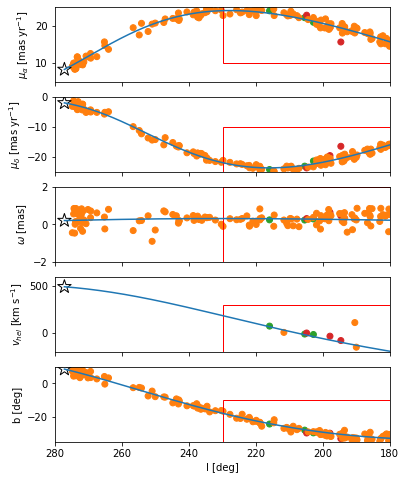

In [19]:
cand_sc = coord.SkyCoord(ra=cand['ra'].values*u.deg,
                         dec=cand['dec'].values*u.deg,
                         pm_ra_cosdec=cand['pmra'].values*u.mas/u.yr,
                         pm_dec=cand['pmdec'].values*u.mas/u.yr,
                         radial_velocity=cand['v_hel'].values*u.km/u.s) 
sc_icrs = cand_sc.transform_to(coord.ICRS)
sc_gal = cand_sc.transform_to(coord.Galactic)
colormap = {'Y': 'C2', 'N': 'C3', 'NA': 'C1'}
colors = [colormap[choice] for choice in cand['good_cand_ibata']]

fig, ax = plt.subplots(5, 1, sharex='col', sharey='row', figsize=(6,8))
ax[-1].set_xlim(280,180)
ax[-1].set_xlabel('l [deg]')

# pm_ra
ax[0].plot(orbit_gal.l, orbit_icrs.pm_ra_cosdec)
ax[0].scatter(sc_gal.l, sc_icrs.pm_ra_cosdec, c=colors)
ax[0].scatter(orbit_gal[0].l, orbit_icrs[0].pm_ra_cosdec, marker='*', s=200, facecolors='none', edgecolors='k')
ax[0].set_ylim(5,25)
ax[0].set_ylabel(r'$\mu_\alpha$ [mas yr$^{-1}$]')

# pm_dec
ax[1].plot(orbit_gal.l, orbit_icrs.pm_dec)
ax[1].scatter(sc_gal.l, sc_icrs.pm_dec, c=colors)
ax[1].scatter(orbit_gal[0].l, orbit_icrs[0].pm_dec, marker='*', s=200, facecolors='none', edgecolors='k')
ax[1].set_ylim(-25,0)
ax[1].set_ylabel(r'$\mu_\delta$ [mas yr$^{-1}$]')

# parallax
ax[2].plot(orbit_gal.l, orbit_icrs.distance.parallax)
ax[2].scatter(sc_gal.l, cand['parallax'], c=colors)
ax[2].scatter(orbit_gal[0].l, orbit_icrs[0].distance.parallax, marker='*', s=200, facecolors='none', edgecolors='k')
ax[2].set_ylim(-2,2)
ax[2].set_ylabel(r'$\omega$ [mas]')

# v_hel
ax[3].plot(orbit_gal.l, orbit_icrs.radial_velocity)
ax[3].scatter(orbit_gal[0].l, orbit_icrs[0].radial_velocity, marker='*', s=200, facecolors='none', edgecolors='k')
ax[3].scatter(sc_gal.l, sc_icrs.radial_velocity, c=colors)
ax[3].set_ylim(-200,600)
ax[3].set_ylabel(r'$v_{hel}$ [km s$^{-1}$]')

# sky position
ax[4].plot(orbit_gal.l, orbit_gal.b)
ax[4].scatter(sc_gal.l, sc_gal.b, c=colors)
ax[4].scatter(orbit_gal[0].l, orbit_gal[0].b, marker='*', s=200, facecolors='none', edgecolors='k')
ax[4].set_ylim(-35,10)
ax[4].set_ylabel('b [deg]');

# add rectangles
rect_dict = {'linewidth': 1, 'edgecolor': 'r', 'facecolor': 'none'}
ax[0].add_patch(Rectangle((180,10),50,30,**rect_dict))
ax[1].add_patch(Rectangle((180,-40),50,30,**rect_dict))
ax[2].add_patch(Rectangle((180,-2),50,4,**rect_dict))
ax[3].add_patch(Rectangle((180,-200),50,500,**rect_dict))
ax[4].add_patch(Rectangle((180,-40),50,30,**rect_dict));

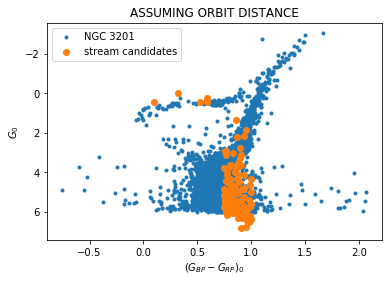

In [20]:
plt.scatter(df['bp_rp0'][sel & in_cluster], G[sel & in_cluster], marker='.', label='NGC 3201')
plt.scatter(df['bp_rp0'][good], G[good], marker='o', label='stream candidates')
plt.gca().invert_yaxis()
plt.xlabel(r'$(G_{BP} - G_{RP})_0$')
plt.ylabel(r'$G_0$')
plt.title('ASSUMING ORBIT DISTANCE')
plt.legend(loc='best');

In [21]:
cols = ['other_id', 'coordstring', 'johnson_V', 'good_cand_ibata', 'v_hel', 'v_hel_err', 'v_hel_ibata', 'v_hel_err_ibata', 'ra', 'dec', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'parallax', 'parallax_error', 'g', 'bp_rp', 'g0', 'bp_rp0', 'r_est', 'r_lo', 'r_hi', 'result_flag', 'modality_flag']
cand = cand[cols]
cand

,other_id,coordstring,johnson_V,good_cand_ibata,v_hel,v_hel_err,v_hel_ibata,v_hel_err_ibata,ra,dec,...,parallax_error,g,bp_rp,g0,bp_rp0,r_est,r_lo,r_hi,result_flag,modality_flag
source_id,,,,,,,,,,,,,,,,,,,,,
2985543956292701312,ibata_6,05h28m25.0221s -13d20m24.0247s,16.37667,Y,74.41,1.51,74.41,1.51,82.10426,-13.34001,...,0.05417,16.18516,0.98242,15.74844,0.77101,3210.51108,2762.55179,3798.20476,1,1
3187390548572555136,gjoll_2,04h58m30.5583s -06d25m24.1523s,13.49105,Y,-10.30,0.60,-10.92,0.28,74.62733,-6.42338,...,0.02200,13.25975,1.09116,13.14499,1.03561,3695.52912,3422.63987,4012.29832,1,1
3188058536245928576,ibata_5,04h51m23.5801s -06d45m31.5986s,16.67845,N,0.81,3.18,0.81,3.18,72.84825,-6.75878,...,0.06180,16.56450,0.72630,16.40683,0.64998,2637.39435,2283.18179,3099.73007,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5605084367423717376,,07h15m04.7722s -31d35m14.7587s,19.44455,NA,NaN,NaN,NaN,NaN,108.76988,-31.58743,...,0.24614,19.17861,1.17780,18.79485,0.99203,2332.15166,1425.93614,4472.46043,1,1
2923457523971828480,,06h39m40.2257s -25d17m28.8849s,18.25171,NA,NaN,NaN,NaN,NaN,99.91761,-25.29136,...,0.13353,18.09141,0.88812,17.86976,0.78082,2374.21789,1793.62172,3345.65905,1,1
2936879331131765504,,06h22m10.9874s -22d32m52.8506s,17.65714,NA,NaN,NaN,NaN,NaN,95.54578,-22.54801,...,0.09012,17.47613,0.95170,17.26014,0.84715,4735.90299,3693.86462,6180.63445,1,1


In [22]:
# cand.to_csv('notebooks/gjoll-candidates/list-2019Dec21.csv')

In [27]:
cand[cand['g'] < 17]

,other_id,coordstring,johnson_V,good_cand_ibata,v_hel,v_hel_err,v_hel_ibata,v_hel_err_ibata,ra,dec,...,parallax_error,g,bp_rp,g0,bp_rp0,r_est,r_lo,r_hi,result_flag,modality_flag
source_id,,,,,,,,,,,,,,,,,,,,,
2985543956292701312,ibata_6,05h28m25.0221s -13d20m24.0247s,16.37667,Y,74.41,1.51,74.41,1.51,82.10426,-13.34001,...,0.05417,16.18516,0.98242,15.74844,0.77101,3210.51108,2762.55179,3798.20476,1,1
3187390548572555136,gjoll_2,04h58m30.5583s -06d25m24.1523s,13.49105,Y,-10.30,0.60,-10.92,0.28,74.62733,-6.42338,...,0.02200,13.25975,1.09116,13.14499,1.03561,3695.52912,3422.63987,4012.29832,1,1
3188058536245928576,ibata_5,04h51m23.5801s -06d45m31.5986s,16.67845,N,0.81,3.18,0.81,3.18,72.84825,-6.75878,...,0.06180,16.56450,0.72630,16.40683,0.64998,2637.39435,2283.18179,3099.73007,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5411396284562095360,,09h47m52.0214s -46d49m38.5646s,17.19318,NA,NaN,NaN,NaN,NaN,146.96676,-46.82738,...,0.05587,16.78581,1.48046,15.52195,0.86866,5321.62818,4225.82162,6922.64087,1,1
3254698316801283328,,04h22m06.5462s -00d26m33.1789s,16.95178,NA,NaN,NaN,NaN,NaN,65.52728,-0.44255,...,0.09475,16.75388,1.00069,16.56722,0.91033,1589.07068,1380.87738,1863.04466,1,1
5544088135244216192,,08h07m23.4875s -37d26m43.4336s,16.15852,NA,NaN,NaN,NaN,NaN,121.84786,-37.44540,...,0.03016,15.61837,1.71728,12.73385,0.32094,4211.61518,3722.50491,4839.47594,1,1
